In [ ]:
import json
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [ ]:
#### DRIVE'A BAĞLAN, AÇILAN LİNKE TIKLA, ORADAKİ KODU ÇIKAN KUTUCUĞA YAPITŞIR

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#### PATHLERINI UYGUN BİR ŞEKİLDE YAZARAK DATASET VS.'YI UNZIPLE

!unzip 'drive/My Drive/NLP-Project/SeqToLang.zip'
!unzip 'drive/My Drive/NLP-Project/default_label2id.json.zip'
!unzip 'drive/My Drive/NLP-Project/Spanish.txt.zip'
!unzip 'drive/My Drive/NLP-Project/English.txt.zip'
!unzip 'drive/My Drive/NLP-Project/French.txt.zip'
!unzip 'drive/My Drive/NLP-Project/Portuguese.txt.zip'
!unzip 'drive/My Drive/NLP-Project/Italian.txt.zip'
!unzip 'drive/My Drive/NLP-Project/German.txt.zip'

Archive:  drive/My Drive/NLP-Project/SeqToLang.zip
   creating: seqtolang/
   creating: seqtolang/checkpoints/
  inflating: seqtolang/checkpoints/default_label2id.json  
  inflating: seqtolang/checkpoints/default_model.state_dict  
  inflating: seqtolang/checkpoints/default_vectorizer.pickle  
  inflating: seqtolang/detector.py   
  inflating: seqtolang/model.py      
  inflating: seqtolang/vectorizer.py  
  inflating: seqtolang/__init__.py   
   creating: seqtolang/__pycache__/
  inflating: seqtolang/__pycache__/detector.cpython-37.pyc  
  inflating: seqtolang/__pycache__/model.cpython-37.pyc  
  inflating: seqtolang/__pycache__/vectorizer.cpython-37.pyc  
  inflating: seqtolang/__pycache__/__init__.cpython-37.pyc  
Archive:  drive/My Drive/NLP-Project/default_label2id.json.zip
  inflating: default_label2id.json   
  inflating: __MACOSX/._default_label2id.json  
Archive:  drive/My Drive/NLP-Project/Spanish.txt.zip
  inflating: Spanish.txt             
  inflating: __MACOSX/._Spanish.t

In [ ]:
### BURASI VECTORIZER CLASSININ TANIMLANDIĞI YER

import re
import itertools
import numpy as np
from collections import Counter

TOKENIZER_REGEX = re.compile(r"[^\d\W]+", re.UNICODE)
PAD_INDEX = 0
UNK_INDEX = 1
CHUNK_SIZE = 60000
MIN_NGRAM_FREQ = 2
TOKEN_PREFIX = '<'
TOKEN_SUFFIX = '>'


class SeqToLangVectorizer():
    def __init__(self, chars_ngram_range=(2,4), words_tokenizer=None):
        self.words_tokenizer = words_tokenizer or _default_tokenizer
        self.chars_ngram_range = chars_ngram_range
        self.max_words = 0
        self.max_ngrams = 0
        self.ngram2id = None
        self.ngrams_counter = Counter()

    def fit(self, texts):
        self.fit_tokens_stats(texts)
        self.build_ngram2id()
        self.ngrams_counter = None
        return self

    def fit_tokens_stats(self, texts):
        for chunk in _chunkenize(texts, CHUNK_SIZE):
            tokenized_text = self.tokenize(chunk)

            for tokens in tokenized_text:
                if len(tokens) > self.max_words:
                    self.max_words = len(tokens)
                try:
                  max_chars_len = max(map(len, tokens))
                  if max_chars_len > self.max_ngrams:
                      self.max_ngrams = max_chars_len

                  self.ngrams_counter.update(itertools.chain(*tokens))
                except:
                  pass

    def vectorize(self, texts):
        tokenized_texts = self.tokenize(texts)
        vectors = list(map(self.convert_token_to_ids, tokenized_texts))
        padded_texts = self.pad_tokenized_texts(vectors)
        return np.array(padded_texts, dtype=np.int)

    def tokenize(self, texts):
        return list(map(self.tokenize_single, texts))

    def build_ngram2id(self):
        self.ngram2id = {'__PAD__': PAD_INDEX, '__UNK__': UNK_INDEX}
        for ngram, cnt in self.ngrams_counter.most_common():
            if cnt < MIN_NGRAM_FREQ: break
            if ngram not in {TOKEN_PREFIX, TOKEN_SUFFIX}:
                self.ngram2id[ngram] = len(self.ngram2id)

    def pad_tokenized_texts(self, tokenized_texts):
        padded = []
        for tokens in tokenized_texts:
            padded_tokens = list(map(self.pad_single_token, tokens))
            padded.append(padded_tokens[:self.max_words] + [np.zeros(self.max_ngrams)]*(self.max_words - len(padded_tokens)))
        return padded

    def pad_single_token(self, token):
        return token[:self.max_ngrams] + [0]*(self.max_ngrams - len(token))

    def tokenize_single(self, text):
        tokens = self.words_tokenizer(text)
        tokens = list(map(self.chars_tokenizer, tokens))

        return list(tokens)

    def chars_tokenizer(self, token):
        token = TOKEN_PREFIX + token + TOKEN_SUFFIX
        ngrams = set()
        for ngram_size in range(self.chars_ngram_range[0], self.chars_ngram_range[1]+1):
            grams = zip(*[token[i:] for i in range(ngram_size)])
            ngrams |= {"".join(g) for g in grams}

        return ngrams

    def convert_token_to_ids(self, token):
        return list(map(self.convert_ngrams_to_ids, token))

    def convert_ngrams_to_ids(self, ngrams):
        if not self.ngram2id:
            raise Exception('SeqToLangVectorizer not fitted')

        ngram_ids = []
        for gram in ngrams:
            gram_id = self.ngram2id.get(gram)
            if gram_id: ngram_ids.append(gram_id)
        return ngram_ids


def _default_tokenizer(text):
    return TOKENIZER_REGEX.findall(text.lower().strip())


def _chunkenize(l, n):
    print(type(l), type(n))
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [ ]:
### BURADA TÜM DOSYA OKUNUP DATAFRAME OLUŞTURULUYOR. LENS'E GÖRE ELEME YAPIL-MI-YOR

language_files = {"ing":"English.txt", "spa":"Spanish.txt", "fra":"French.txt", 
                  "porto":"Portuguese.txt", "ita":"Italian.txt", "deu":"German.txt"}

sentences = {}
for lang in language_files.keys():
  text = open(language_files[lang], encoding='utf8')
  sentences[lang] = text.readlines()
  text.close()

my_list = []
for sentence_number in range(10000):
  for label in sentences.keys():
    sentence = sentences[label][sentence_number].replace('"','').replace('\n','')
    #v = torch.tensor(vectorizer.vectorize([sentence])).long()
    #lens = torch.sum(v.sum(2) > 0, dim=1)
    if True:
      dic_key = {"Sentence": sentence, "Label": label}
      my_list.append(dic_key)

my_data = pd.DataFrame(my_list)

In [ ]:
### YENI BIR VECTORIZER OLUŞTURULUP EĞİTİLİYOR. VECTORIZERI OLUŞTURURKEN GİRDİĞİN
### CHARS_NGRAM_RANGE DEGERINE GORE DOSYA ADINI GUNCELLEMEYI UNUTMA.
### OLUSTURULAN PICKLELARI SOLDAKI MENUDEN BILGISAYARINA INDIRMEYI UNUTMA
### ZAMANLA KAYBOLABILIR

vectorizer = SeqToLangVectorizer(chars_ngram_range=(2,4))
vectorizer.fit(my_data['Sentence'].astype(str))
with open('2-4vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)

In [ ]:
### VECTORIZER'I PICKLELAMAYI COMMENT LINE'A ALDIM, EĞER SON OLUŞTURDUĞUN VECTORIZERI DEĞİL DE
### ESKILERDEN BIRINI KULLANMAK ISTERSEN VECTORIZER PATHINI GUNCELLE

LANG_PROBA_THRESHOLD = 0.05
DEFAULT_HIDDEN_SIZE = 32
DEFAULT_EMBEDDING_DIM = 16
label2id = json.load(open('default_label2id.json', 'r'))
id2label = {0:'Eng', 1:'Spa', 2:'Fre', 3:"Por", 4:'Ita', 5:'Deu'}
vectorizer = pickle.load(open('3-6vectorizer.pickle', 'rb'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Language_Dataset(Dataset):
  
  def __init__(self, my_data):
    self.my_data = my_data

  def __len__(self):
    return len(self.my_data)

  def __getitem__(self, index):
    sentence = my_data.loc[index,"Sentence"]
    y = torch.tensor(label2id[my_data.loc[index,"Label"]])

    return sentence, y

class Model(nn.Module):

  def __init__(self, num_of_ngrams, output_size, hidden_size, embedding_dim):
    super().__init__()
    self.chars_embedding = nn.Embedding(num_embeddings=num_of_ngrams, padding_idx=0, embedding_dim=embedding_dim)
    self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, bidirectional=True, batch_first=True)
    self.linear = nn.Linear(hidden_size*2, output_size)
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  def forward(self, tokenized_texts):
    batch_size = tokenized_texts.shape[0]
    num_of_words = tokenized_texts.shape[1]
    num_of_ngrams = tokenized_texts.shape[2]

    lens = torch.sum(tokenized_texts.sum(2) > 0, dim=1)

    x = tokenized_texts.view(batch_size * num_of_words, num_of_ngrams)
    embedded = self.chars_embedding(x)
    embedded = embedded.view(batch_size, num_of_words, num_of_ngrams, -1)
    embedded_sum = embedded.sum(2) / lens.view(batch_size, 1, 1).float()

    pack = pack_padded_sequence(embedded_sum, lens, batch_first=True, enforce_sorted=False)
    rnn_outputs, last_hidden = self.rnn(pack)
    unpacked, unpacked_len = pad_packed_sequence(rnn_outputs, batch_first=True)
    unpacked = torch.mean(unpacked, 1)
    output = self.linear(unpacked)

    return output

def train(epoch_count, batch_size, learning_rate, train_data, val_data, net=None):
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
  if net==None:
    net = Model(num_of_ngrams=len(vectorizer.ngram2id),
                output_size=6,
                hidden_size=DEFAULT_HIDDEN_SIZE,
                embedding_dim=DEFAULT_EMBEDDING_DIM).to(device)
  net.cuda()
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  
  for epoch_num in range(epoch_count):
    
    net.train()
    correct_train = 0
    total_train_loss = 0
    for data, target in train_loader:
      data = torch.tensor(vectorizer.vectorize(data)).long()
      data, target = Variable(data).to(device), Variable(target).to(device)
      optimizer.zero_grad()
      output = F.log_softmax(net(data))
      loss = F.nll_loss(output, target)
      loss.backward()
      optimizer.step()
      _, predicted = torch.max(output.data, 1)
      correct_train += (predicted == target).float().sum().item()
      total_train_loss += loss.item() * len(data)

    net.eval()
    correct_val = 0
    total_val_loss = 0
    for data, target in val_loader:
      data = torch.tensor(vectorizer.vectorize(data)).long()
      data, target = Variable(data).to(device), Variable(target).to(device)
      output = F.log_softmax(net(data))
      loss = F.nll_loss(output, target)
      _, predicted = torch.max(output.data, 1)
      correct_val += (predicted == target).float().sum().item()
      total_val_loss += loss.item() * len(data)

    train_losses.append(total_train_loss/len(train_loader.dataset))
    train_accuracies.append(correct_train/len(train_loader.dataset))
    val_losses.append(total_val_loss/len(val_loader.dataset))
    val_accuracies.append(correct_val/len(val_loader.dataset))

    pickle_name = "drive/My Drive/NLP-Project/net" + str(epoch_num) + ".pickle"
    with open(pickle_name, 'wb') as f:
      pickle.dump(net, f)
    
    torch.cuda.empty_cache()
  
  return net, train_losses, train_accuracies, val_losses, val_accuracies

def test(batch_size, test_data, net):
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
  net.cuda()
  net.eval()
  correct = 0
  total_loss = 0
  wrong_labeled = []
  reals = []
  preds = []
  for data_text, target in test_loader:
    data = torch.tensor(vectorizer.vectorize(data_text)).long()
    data, target = Variable(data).to(device), Variable(target).to(device)
    output = F.log_softmax(net(data))
    loss = F.nll_loss(output, target)
    _, predicted = torch.max(output.data, 1)
    reals += list(target.float().cpu())
    preds += list(predicted.float().cpu())
    correct += (predicted == target).float().sum().item()
    label_correction = (predicted==target)
    for i, isCorrect in enumerate(label_correction):
      if not isCorrect:
        info = [data_text[i], int(predicted[i].cpu()), int(target[i].cpu())]
        wrong_labeled.append(info)
    total_loss += loss.item() * len(data)

  return reals, preds, total_loss/len(test_loader.dataset), correct/len(test_loader.dataset), wrong_labeled

In [ ]:
### VECTORIZER'A GORE LENS ALIP ONA GORE SUBSET OLUŞTURUYOR

language_files = {"ing":"English.txt", "spa":"Spanish.txt", "fra":"French.txt", 
                  "porto":"Portuguese.txt", "ita":"Italian.txt", "deu":"German.txt"}

sentences = {}
for lang in language_files.keys():
  text = open(language_files[lang], encoding='utf8')
  sentences[lang] = text.readlines()
  text.close()

my_list = []
for sentence_number in range(10000):
  for label in sentences.keys():
    sentence = sentences[label][sentence_number].replace('"','').replace('\n','')
    v = torch.tensor(vectorizer.vectorize([sentence])).long()
    lens = torch.sum(v.sum(2) > 0, dim=1)
    if lens>0:
      dic_key = {"Sentence": sentence, "Label": label}
      my_list.append(dic_key)

my_data = pd.DataFrame(my_list)

In [ ]:
### DATASETLERI OLUSTUR

my_train, my_test = train_test_split(my_data, test_size=0.2, random_state=42)
my_train, my_validation = train_test_split(my_train, test_size=0.125, random_state=42)
train_dataset = Language_Dataset(my_train)
val_dataset = Language_Dataset(my_validation)
test_dataset = Language_Dataset(my_test)

In [ ]:
### MODELI RUNLA
### RETURNLENEN DEĞERLER
##### MODEL: OLUŞTURDUĞUN MODEL :d
##### tr_l: HER EPOCH ICIN TRAIN LOSSLARINI ICEREN LISTE
##### tr_l: HER EPOCH ICIN TRAIN ACCURACYLERINI ICEREN LISTE
##### va_l: HER EPOCH ICIN VALIDATION LOSSLARINI ICEREN LISTE
##### va_a: HER EPOCH ICIN VALIDATION ACCURACYLERINI ICEREN LISTE

### EGER BIR MODELI BIR MIKTAR EGITTIKTEN SONRA BIRAZ DAHA EGITMEK ISTERSEN,
### COMMENT LINESIZ OLANI COMMENT LINE'A AL, DİĞERİNİ ÇIKART

net, tr_l, tr_a, va_l, va_a = train(epoch_count=12, batch_size=32, learning_rate=0.01, train_data=train_dataset, val_data=val_dataset)
#net, tr_l, tr_a, va_l, va_a = train(epoch_count=2, batch_size=8, learning_rate=0.01, train_dataset, val_dataset, net=net)

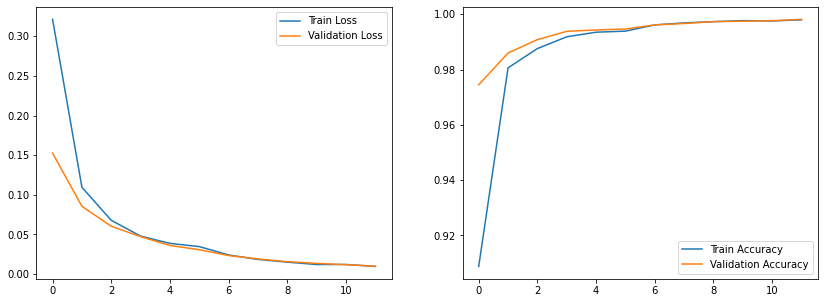

In [ ]:
### YUKARIDAKI FONKSIYONDAN DONEN DEGERLERE GORE GRAFIK CIZDIR
### EN SON SATIRDAKI ISIMLE KAYDET
### OLUSTURULAN FOTOĞRAFLARI SOLDAKI MENUDEN KENDI BILGISAYARINA INDIRMEYI
### UNUTMA ZAMANLA KAYBOLABILIR

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(tr_l, label='Train Loss')
plt.plot(va_l, label='Validation Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(tr_a, label='Train Accuracy')
plt.plot(va_a, label='Validation Accuracy')
plt.legend()
plt.savefig("drive/My Drive/NLP-Project/32-01.jpg")

In [ ]:
reals, preds, te_l, te_a, wrong_labeled = test(32, test_dataset, net)

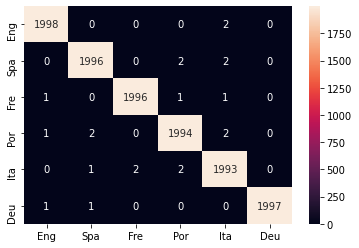

In [ ]:
cm = confusion_matrix(reals, preds)
matrix_labels = ['Eng', 'Spa', 'Fre', 'Por', 'Ita', 'Deu']
myFig = sn.heatmap(cm, annot=True, fmt='d', xticklabels=matrix_labels, yticklabels=matrix_labels).get_figure()
plt.savefig("drive/My Drive/NLP-Project/32-01confusion_matrix.jpg")

out = open("drive/My Drive/NLP-Project/32-01wrong.txt", "w+")
for sentence in wrong_labeled:
  out_text = "Sentence: " + sentence[0] + "\nPrediction: " + id2label[sentence[1]] + "\nTrue Label: " + id2label[sentence[2]] + "\n\n\n"
  out.write(out_text)
out.close()